Epoch 0/500, Loss: 13.83
Epoch 50/500, Loss: 13.83
Epoch 100/500, Loss: 13.83
Epoch 150/500, Loss: 13.79
Epoch 200/500, Loss: 13.56
Epoch 250/500, Loss: 13.13
Epoch 300/500, Loss: 12.93
Epoch 350/500, Loss: 12.89
Epoch 400/500, Loss: 12.89
Epoch 450/500, Loss: 12.89
Epoch 500/500, Loss: 12.88
Epoch 550/500, Loss: 12.89
Epoch 600/500, Loss: 12.88
Epoch 650/500, Loss: 12.88
Epoch 700/500, Loss: 12.90
Epoch 750/500, Loss: 12.88
Epoch 800/500, Loss: 12.88
Epoch 850/500, Loss: 12.88
Epoch 900/500, Loss: 12.88
Epoch 950/500, Loss: 12.88
Epoch 1000/500, Loss: 12.88
Epoch 1050/500, Loss: 12.88
Epoch 1100/500, Loss: 12.88
Epoch 1150/500, Loss: 12.88
Epoch 1200/500, Loss: 12.89
Epoch 1250/500, Loss: 12.89
Epoch 1300/500, Loss: 12.88
Epoch 1350/500, Loss: 12.89
Epoch 1400/500, Loss: 12.88
Epoch 1450/500, Loss: 12.88
Epoch 1500/500, Loss: 12.88
Epoch 1550/500, Loss: 12.89
Epoch 1600/500, Loss: 12.88
Epoch 1650/500, Loss: 12.88
Epoch 1700/500, Loss: 12.88
Epoch 1750/500, Loss: 12.88
Epoch 1800/500,

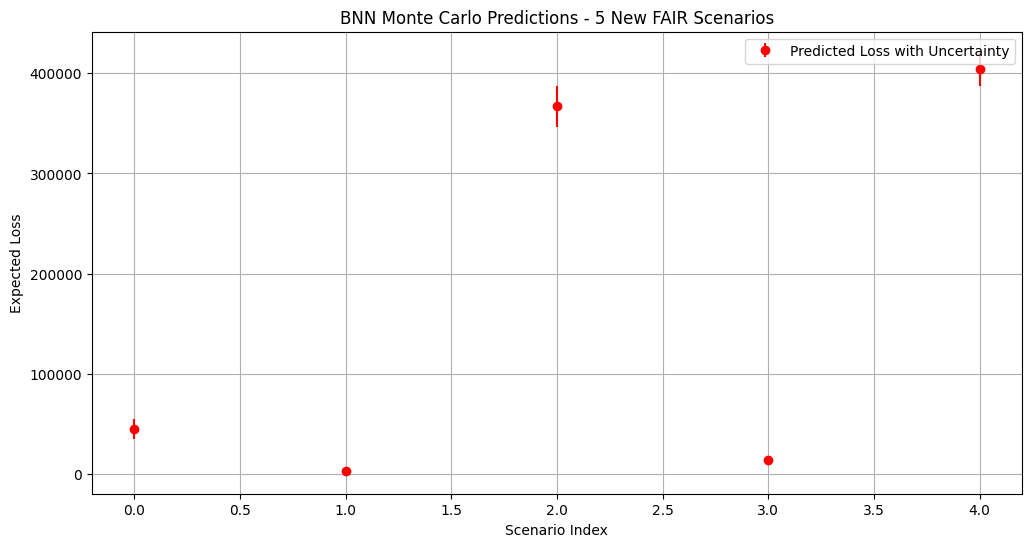

Scenario 1
  Asset Value: 158,240
  Threat Event Frequency: 1.94
  Vulnerability: 0.27
  Loss Magnitude: 128,054
  Expected Loss (True): 67,461
  Predicted Loss (Mean): 45,207
  Predicted Uncertainty (Std): 10,294
----------------------------------------
Scenario 2
  Asset Value: 357,090
  Threat Event Frequency: 0.24
  Vulnerability: 0.59
  Loss Magnitude: 59,695
  Expected Loss (True): 8,318
  Predicted Loss (Mean): 2,813
  Predicted Uncertainty (Std): 1,356
----------------------------------------
Scenario 3
  Asset Value: 492,894
  Threat Event Frequency: 4.21
  Vulnerability: 0.91
  Loss Magnitude: 80,509
  Expected Loss (True): 309,291
  Predicted Loss (Mean): 366,976
  Predicted Uncertainty (Std): 20,248
----------------------------------------
Scenario 4
  Asset Value: 336,110
  Threat Event Frequency: 1.81
  Vulnerability: 0.77
  Loss Magnitude: 48,680
  Expected Loss (True): 67,491
  Predicted Loss (Mean): 13,772
  Predicted Uncertainty (Std): 4,132
--------------------------

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.preprocessing import StandardScaler

# 랜덤 시드 고정
torch.manual_seed(10171927)
np.random.seed(10171927)

# ----------------------------
# 1. 랜덤 생성 FAIR 데이터셋 (10000개 시나리오)
# ----------------------------
n_samples = 10000  # 학습 데이터 크기

# 랜덤 데이터 생성 (현실적 분포 고려 가능)
asset_value = np.random.uniform(100000, 500000, n_samples)
threat_event_frequency = np.random.uniform(0.1, 5, n_samples)
vulnerability = np.random.uniform(0.1, 1, n_samples)
loss_magnitude = np.random.uniform(10000, 200000, n_samples)

# 기대 손실 계산
loss_event_frequency = threat_event_frequency * vulnerability
expected_loss = loss_event_frequency * loss_magnitude

X = np.column_stack([asset_value, threat_event_frequency, vulnerability, loss_magnitude, loss_event_frequency])
y = expected_loss

# 데이터 스케일링 (BNN 학습 안정성 확보)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PyTorch Tensor로 변환
X_train = torch.tensor(X_scaled, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# ----------------------------
# 2. Bayesian Linear Layer 정의
# ----------------------------
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_logvar = nn.Parameter(torch.zeros(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.zeros(out_features))
        self.bias_logvar = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        weight_std = torch.exp(0.5 * self.weight_logvar)
        bias_std = torch.exp(0.5 * self.bias_logvar)

        weight = self.weight_mu + weight_std * torch.randn_like(weight_std)
        bias = self.bias_mu + bias_std * torch.randn_like(bias_std)

        return F.linear(x, weight, bias)

# ----------------------------
# 3. Bayesian Neural Network 정의
# ----------------------------
class BayesianNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, 32)
        self.blinear2 = BayesianLinear(32, 32)
        self.blinear3 = BayesianLinear(32, 1)

    def forward(self, x):
        x = F.relu(self.blinear1(x))
        x = F.relu(self.blinear2(x))
        return self.blinear3(x)

# ----------------------------
# 4. Negative Log Likelihood Loss 정의
# ----------------------------
def negative_log_likelihood(y_true, y_pred, std=10000.0):
    dist = Normal(y_pred, std)
    return -dist.log_prob(y_true).mean()

# ----------------------------
# 5. 학습 루프 (10000개 시나리오 학습)
# ----------------------------
model = BayesianNN(input_dim=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(2500):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = negative_log_likelihood(y_train, y_pred, std=np.std(y_train.numpy()))
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}/500, Loss: {loss.item():.2f}")

# ----------------------------
# 6. 5개 새로운 시나리오 생성 (Inference 데이터)
# ----------------------------
n_inference_samples = 5
asset_value_inf = np.random.uniform(100000, 500000, n_inference_samples)
threat_event_frequency_inf = np.random.uniform(0.1, 5, n_inference_samples)
vulnerability_inf = np.random.uniform(0.1, 1, n_inference_samples)
loss_magnitude_inf = np.random.uniform(10000, 200000, n_inference_samples)

loss_event_frequency_inf = threat_event_frequency_inf * vulnerability_inf

X_inf = np.column_stack([
    asset_value_inf, 
    threat_event_frequency_inf, 
    vulnerability_inf, 
    loss_magnitude_inf, 
    loss_event_frequency_inf
])

# 스케일 변환
X_inf_scaled = scaler.transform(X_inf)

# ----------------------------
# 7. Monte Carlo 기반 예측 함수
# ----------------------------
@torch.no_grad()
def monte_carlo_predictions(model, X, n_samples=100):
    model.eval()
    preds = np.zeros((n_samples, len(X)))
    X = torch.tensor(X, dtype=torch.float32)

    for i in range(n_samples):
        preds[i] = model(X).squeeze().numpy()

    return preds.mean(axis=0), preds.std(axis=0)

# ----------------------------
# 8. Monte Carlo 예측 및 시각화
# ----------------------------
pred_mean, pred_std = monte_carlo_predictions(model, X_inf_scaled)

plt.figure(figsize=(12, 6))
plt.errorbar(range(len(pred_mean)), pred_mean, yerr=pred_std, fmt='o', color='red', label='Predicted Loss with Uncertainty')
plt.xlabel('Scenario Index')
plt.ylabel('Expected Loss')
plt.title('BNN Monte Carlo Predictions - 5 New FAIR Scenarios')
plt.legend()
plt.grid(True)
plt.show()

# 5개 시나리오의 실제 데이터와 예측 결과 출력
for i in range(n_inference_samples):
    print(f"Scenario {i+1}")
    print(f"  Asset Value: {asset_value_inf[i]:,.0f}")
    print(f"  Threat Event Frequency: {threat_event_frequency_inf[i]:.2f}")
    print(f"  Vulnerability: {vulnerability_inf[i]:.2f}")
    print(f"  Loss Magnitude: {loss_magnitude_inf[i]:,.0f}")
    print(f"  Expected Loss (True): {loss_event_frequency_inf[i] * loss_magnitude_inf[i]:,.0f}")
    print(f"  Predicted Loss (Mean): {pred_mean[i]:,.0f}")
    print(f"  Predicted Uncertainty (Std): {pred_std[i]:,.0f}")
    print("-" * 40)
